Run the below code first to access ToTensorV2


In [ ]:
! pip install albumentations==0.4.6

In [2]:
from albumentations.pytorch import ToTensorV2

In [4]:
import torch as T
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import  transforms
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
from tqdm import tqdm
import albumentations as A

Dataset Import

In [9]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Add the downloaded dataset to ur drive and replace the destination to import the datasets.

In [ ]:
! unzip "/gdrive/MyDrive/DeepLearning/mriimages.zip"
! unzip "/gdrive/MyDrive/DeepLearning/segImages.zip"

Creating UNET Model

In [5]:
class Double_conv(nn.Module):
  def __init__(self, in_channels, out_channels):
        super(Double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
 
  def forward(self, x):
    return self.conv(x)

In [6]:
class UNET(nn.Module):
  def __init__(self, input_dim = 1, output_dim = 4):
        super(UNET, self).__init__()
 
        features = [64, 128, 256, 512]
 
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
 
        for feature in features:
          self.downs.append(Double_conv(input_dim,feature))
          input_dim = feature
 
        for feature in reversed(features):
          self.ups.append(
                  nn.ConvTranspose2d(feature*2, feature, 2, 2)
                        )
          self.ups.append(Double_conv(feature*2, feature))
 
        self.pool = nn.MaxPool2d(2, 2)
 
        self.bottom = Double_conv(512, 1024)
        
        self.final = nn.Conv2d(64, output_dim, 1)
  
  def forward(self, x):
    skip_list = []
 
    for down in self.downs:
      x = down(x)
      skip_list.append(x)
      x = self.pool(x)
 
    x = self.bottom(x)
 
    skip_list = skip_list[::-1]
 
    for up in range(0, len(self.ups), 2):
      x = self.ups[up](x)
      skip_val = skip_list[up//2]
      
      if x.shape != skip_val.shape:
        x = TF.resize(x, size=skip_val.shape[2:])
 
      x = T.cat((skip_val, x), 1)
      x = self.ups[up+1](x)
 
    x = self.final(x)
 
    return x

Importing the Datasets

In [11]:
class Heart_dataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms = None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transforms = transforms
        
        self.images = os.listdir(image_dir)
        self.masks = ["seg" + a for a in self.images]
 
    def __len__(self):
        return len(self.images)
 
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])

        image = cv2.imread(img_path,0)
        mask = cv2.imread(mask_path,0)

        image = np.reshape(image, (256,256,1))

        bg = cv2.inRange(mask, 0, 70)
        mask[bg > 200] = 0
        left_ring = cv2.inRange(mask, 127, 190)
        mask[left_ring > 200] = 1
        right = cv2.inRange(mask, 70, 126)
        mask[right > 200] = 2
        left_myo = cv2.inRange(mask, 190, 255)
        mask[left_myo > 200] = 3
 
        if self.transforms is not None:
            aug = self.transforms(image=image, mask=mask)
            image = aug["image"]
            mask = aug["mask"]
 
        return image, mask.long()

In [12]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 4
 
train_transform = A.Compose([A.Resize(height=256,width=256),
                             A.Rotate(limit=30,p=1.0,border_mode=cv2.BORDER_CONSTANT),A.HorizontalFlip(p=0.5),
                             A.VerticalFlip(p=0.1),A.Normalize((0),(1), 255.0),
                             ToTensorV2()])

val_transform = A.Compose([A.Resize(height=256,width=256),
                           A.Normalize((0),(1), 255.0),
                           ToTensorV2()])

dir_img = "/content/mriimages"
dir_mask = "/content/segImages"
 
img_list = os.listdir(dir_img)
mask_list = os.listdir(dir_mask)
 
size = list(range(len(img_list)))
np.random.shuffle(size)
train_idx, val_idx = size[200:], size[10:200]
 
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_data = Heart_dataset(dir_img, dir_mask, train_transform)
train_loader = DataLoader(train_data, BATCH_SIZE, sampler = train_sampler)
 
val_data = Heart_dataset(dir_img, dir_mask, val_transform)
val_loader = DataLoader(val_data, BATCH_SIZE, sampler=val_sampler)

In [13]:
model = UNET(1, 4).to("cuda")
chkpt = T.load("/gdrive/MyDrive/DeepLearning/state_checkpoint.pth.tar")

model.load_state_dict(chkpt["state_dict"])
model=model.cuda()

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

scaler = T.cuda.amp.GradScaler()

for ep in range(2):
  model.train()
  loop = tqdm(train_loader)
  for batch_idx, (data, target) in enumerate(loop):
    data = data.to("cuda")
    target = target.to("cuda")

    with T.cuda.amp.autocast():
      pred = model.forward(data)
      err = loss(pred, target)
      
    optimizer.zero_grad()
    scaler.scale(err).backward()
    scaler.step(optimizer)
    scaler.update()

    loop.set_postfix(loss=err.item())
  print("Trained one epoch")
  #check(model)

  0%|          | 1/402 [00:00<00:55,  7.20it/s, loss=0.0146]

Trained one epoch


100%|██████████| 402/402 [00:58<00:00,  6.89it/s, loss=0.0107]

Trained one epoch


In [14]:
  accuracy = 0
  for i, (x, y) in enumerate(val_loader):
    if x.shape[0] >= 4:
      x = x.cuda()
      y = y.cuda()

      preds = T.softmax(model.forward(x), dim = 1)
      preds = (preds > 0.5).float()

      target = T.eye(4)[y].float()
      target = target.permute(0, 3, 1, 2)
      target = target.type(preds.type())

      correct = (preds == target).sum()
      correct = correct / T.numel(preds)

      accuracy += correct
  accuracy = accuracy / len(val_loader)
  print(accuracy)

tensor(0.9766, device='cuda:0')


In [16]:
checkpoint1 = {
              "state_dict": model.state_dict(),
          }
T.save(checkpoint1, "/gdrive/MyDrive/DeepLearning/state_checkpoint.pth.tar")

In [ ]:
chkpt = T.load("/gdrive/MyDrive/DeepLearning/state_checkpoint.pth.tar")
model.load_state_dict(chkpt["state_dict"])
model=model.cuda()
scaler = T.cuda.amp.GradScaler()
model.eval()

In [19]:
test_transform = A.Compose([A.Resize(height=256,width=256),
                           A.Normalize((0),(1)),
                           ToTensorV2()])
test_idx = size[1500:1510]
test_sampler = SubsetRandomSampler(test_idx)
test_data = Heart_dataset(dir_img, dir_mask, test_transform)
test_loader = DataLoader(test_data, batch_size=1,sampler=test_sampler)

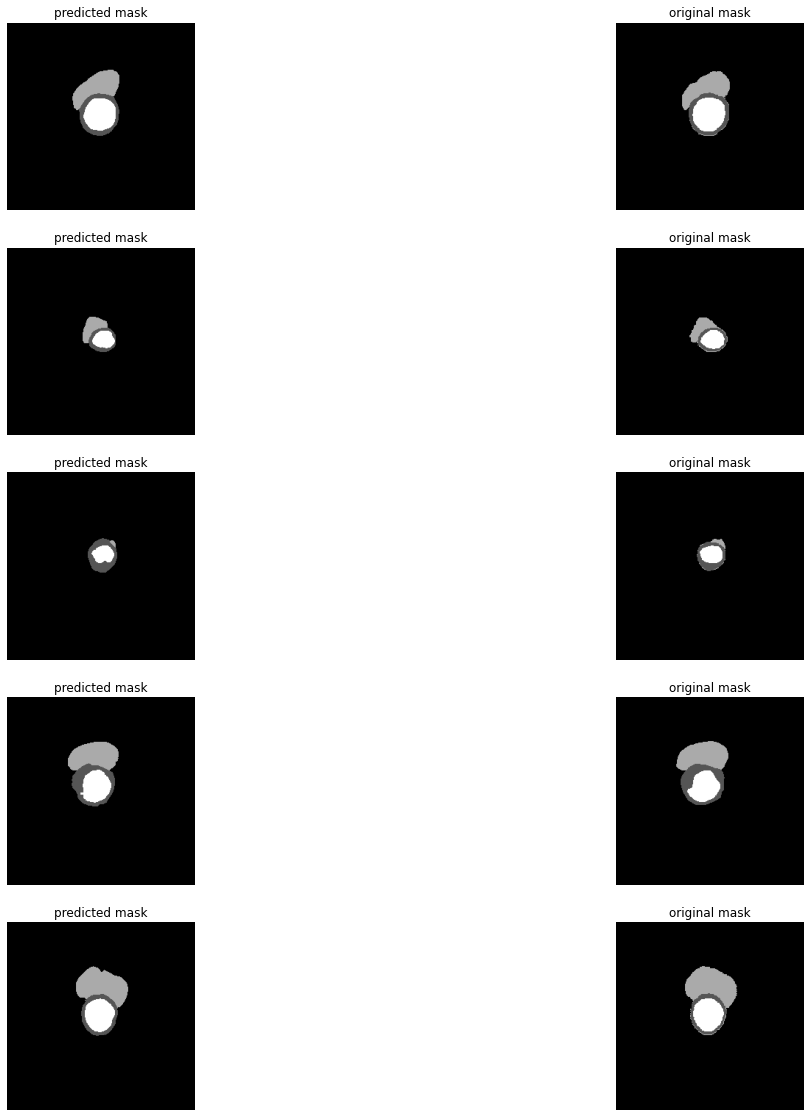

In [22]:
import matplotlib.pyplot as plt
row = 5
columns = 2
fig=plt.figure(figsize=(20, 20))

for batch_idx, (images, labels) in enumerate(test_loader):
  if batch_idx == 5:
    break
  p = model(images.cuda())
  q = T.argmax(p, dim = 1)
  l = labels.squeeze(0).cpu().detach().numpy()
  q = q.squeeze(0).cpu().detach().numpy()

  image,target = q*80, l*80
  
  fig.add_subplot(row, columns, batch_idx*columns + 1)
  plt.axis('off') 
  plt.title("predicted mask")
  plt.imshow(image, cmap=plt.cm.gray)
  
  fig.add_subplot(row, columns, batch_idx*columns + 2)
  plt.axis('off') 
  plt.title("original mask")
  plt.imshow(target, cmap=plt.cm.gray)